In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [18]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# Save references to the tables
Measurement = Base.classes.measurement
Station = Base.classes.station

C:\Users\ranar\AppData\Local\Temp\ipykernel_30196\3044109596.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [22]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [23]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [24]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session

# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Import necessary libraries
from sqlalchemy import func

# Find the most recent date in the data set
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

print(f"The most recent date in the dataset is: {most_recent_date}")


The most recent date in the dataset is: 2017-08-23


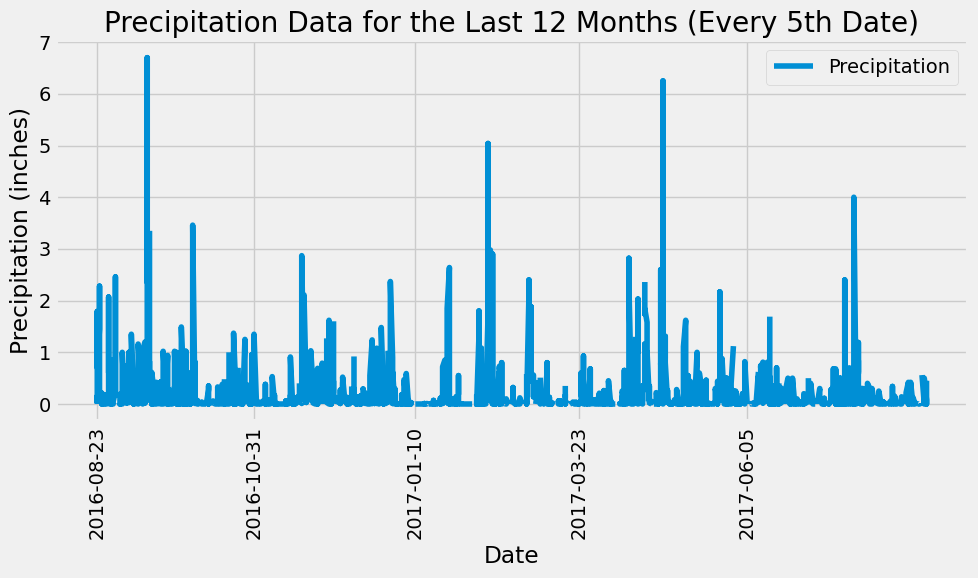

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
import datetime as dt

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime
last_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)

one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
                      .filter(Measurement.date >= one_year_ago_str)\
                      .order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation')

#Select every nth date
n = len(precipitation_df) // 5
selected_dates = precipitation_df.iloc[::n, 0]

plt.xticks(selected_dates, rotation=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data for the Last 12 Months (Every 5th Date)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f'Total number of stations in the dataset: {total_stations}')

Total number of stations in the dataset: 9


In [29]:
from sqlalchemy import desc

# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(desc(func.count(Measurement.station))).all()

print("Most active stations:")
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")


Most active stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station_id).all()

# Print the results
print(f"Most active station ID: {most_active_station_id}")
print(f"Lowest temperature: {temperature_stats[0][0]}")
print(f"Highest temperature: {temperature_stats[0][1]}")
print(f"Average temperature: {temperature_stats[0][2]}")

Most active station ID: USC00519281
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66378066378067


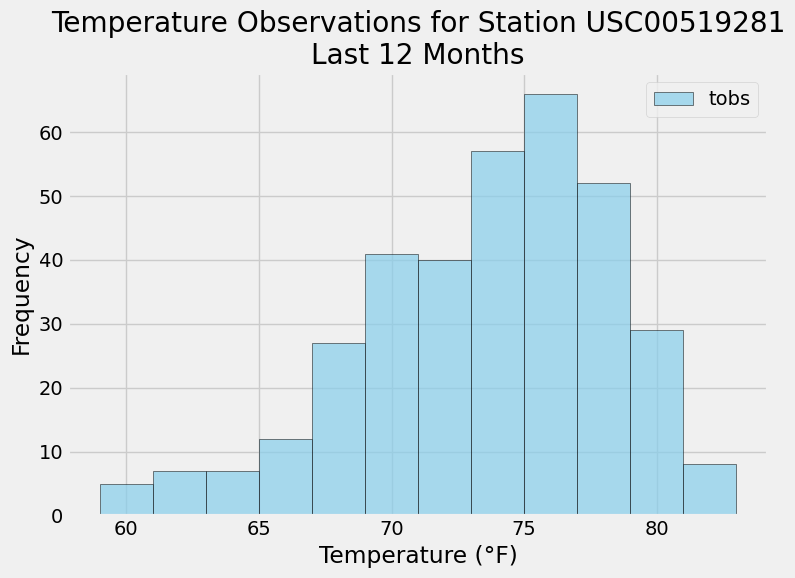

In [31]:
# Using the most active station id
last_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
                   filter(Measurement.station == most_active_station_id).\
                   filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station_id}\nLast 12 Months')
plt.legend(['tobs'], loc='upper right')
plt.tight_layout()
plt.show()


# Close Session

In [32]:
# Close Session
session.close()